# Macroeconomic forecasting: Can machine learning methods outperform traditional approaches?

## 0. Setup of the notebook

The code for the project is too complex to write it solely in this notebook. Here I want to present the results together with the code that produced it. For that reason I use the magic IPython command `%run` to load the modules I wrote myself. Together with the python package `inspect` I can display the source code of the functions I use.  

### Loading packages and modules

In [1]:
import os
import numpy as np
import pandas as pd

# for printing the definition of custom functions
import inspect

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from pmdarima.arima import auto_arima

# pytorch
from torch import nn, no_grad, save, load
from torch import from_numpy, zeros
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset

# plots
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import pickle

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Loading custom modules

In [2]:
# custom module for data handling
%run data_handling

# 1. Data

## 1.1 Real gross domestic product 

The gross domestic product (GDP) is the variable of interest.

Source of the data public availabe on the website of the IMF [here](https://www.imf.org/en/Publications/WEO/weo-database/2020/October/download-entire-database) and provided via an Excel file called `WEOApr2020all.xls`.

In [3]:
file = r"C:\Users\hauer\Dropbox\CFDS\Project\data\WEOApr2020all.csv"
df_weo_real_gdp = pd.read_csv(file)

There are several types of data in this file. This is the description of the relevant subject, the growth of the GDP:

In [4]:
idx = df_weo_real_gdp['Subject Descriptor'] == 'Gross domestic product, constant prices'
df_weo_real_gdp['Subject Notes'] 

df_weo_real_gdp.loc[idx, 'Subject Notes'].unique()

array(['Annual percentages of constant price GDP are year-on-year changes; the base year is country-specific . Expenditure-based GDP is total final expenditures at purchasers? prices (including the f.o.b. value of exports of goods and services), less the f.o.b. value of imports of goods and services. [SNA 1993]'],
      dtype=object)

In [5]:
df_weo_real_gdp.loc[idx, 'Units'].unique()

array(['Percent change'], dtype=object)

The subject code given by the IMF is 'NGDP_RPCH'. This code will also occour in for the weo prediction data. 

In [6]:
df_weo_real_gdp.loc[idx, 'WEO Subject Code'].unique()

array(['NGDP_RPCH'], dtype=object)

As the data for the years are present in the columns of the dataframe, i exctract the relevant information and transpose it afterwars. I want the years as the rows and the variables as the columns. 

In [7]:
df_weo_real_gdp.columns

Index(['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
       'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
       'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', 'Estimates Start After'],
      dtype='object')

This is done with the function: 

In [8]:
print(inspect.getsource(get_imf_woe_data))

def get_imf_woe_data(df_weo_real_gdp, country, remove_na=False):

    df = df_weo_real_gdp[df_weo_real_gdp['Country'] == country]
    
    result = pd.DataFrame()
    
    available_variables = df['Subject Descriptor'].unique()
    
    for variable in available_variables:
        df_curr = df[df['Subject Descriptor'] == variable]
        df_curr = df_curr.iloc[:, 9:49]
        df_curr = df_curr.transpose()
        df_curr = df_curr.rename({df_curr.columns[0]: variable}, axis='columns')
        result = pd.concat([result, df_curr], axis=1)
        
        
    if remove_na:
        result = result.dropna(axis=1) 
        
    return result



To extract the GDP data i use this function: 

In [9]:
print(inspect.getsource(get_gdp_real))

def get_gdp_real(df_weo_real_gdp, country):
    df = get_imf_woe_data(df_weo_real_gdp, country, remove_na=False)
    df.index = df.index.astype(dtype='int64')   
    df['GDP real'] = df['Gross domestic product, constant prices']  
    df['GDP real'] = df['GDP real'].str.replace(',', '').astype('float')
    return df['GDP real']



Here is for example the real GDP growth for germany:

In [10]:
get_gdp_real(df_weo_real_gdp, 'Germany')

1980    1.272
1981    0.110
1982   -0.788
1983    1.555
1984    2.826
1985    2.192
1986    2.417
1987    1.469
1988    3.736
1989    3.913
1990    5.723
1991    5.011
1992    1.925
1993   -0.976
1994    2.395
1995    1.541
1996    0.814
1997    1.790
1998    2.019
1999    1.885
2000    2.905
2001    1.689
2002   -0.201
2003   -0.708
2004    1.186
2005    0.728
2006    3.815
2007    2.975
2008    0.965
2009   -5.694
2010    4.185
2011    3.913
2012    0.428
2013    0.431
2014    2.218
2015    1.742
2016    2.230
2017    2.465
2018    1.522
2019    0.565
Name: GDP real, dtype: float64

The real GDP is availabe for the following 194 (one occurrence is Nan) countries: 

In [11]:
countries_woe_real = df_weo_real_gdp['Country'].unique()
len(countries_woe_real)

195

In [12]:
countries_woe_real

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'The Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Democratic Republic of the Congo', 'Republic of Congo',
       'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'The Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Gui

## 1.2 The variables X

### 1.2.1 IMF

The IMF proivdes some economic variables along with the realised GDP, that are already in the `df_weo_real_gdp` dataframe:

In [13]:
df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, 'Germany', remove_na=False)
df_imf_woe_data.head()

,"Gross domestic product, constant prices","Gross domestic product, current prices","Gross domestic product per capita, constant prices","Inflation, average consumer prices","Inflation, end of period consumer prices",Unemployment rate,General government net lending/borrowing,Current account balance
1980,1.272,867.363,0.931,5.447,NaN,3.359,NaN,-1.782
1981,0.11,950.471,-0.078,6.324,NaN,4.831,NaN,-0.684
1982,-0.788,"1,001.24",-0.717,5.256,NaN,6.734,NaN,0.866
1983,1.555,"1,056.63",1.91,3.284,NaN,8.099,NaN,0.666
1984,2.826,"1,125.70",3.243,2.396,NaN,8.058,NaN,1.423


I will use the following quantities:

In [14]:
imf_woe_variables = ['Inflation, average consumer prices', 'Unemployment rate', 'General government net lending/borrowing', 'Current account balance']

for x in imf_woe_variables:
    idx = df_weo_real_gdp['Subject Descriptor'] == x
    print(x)
    print(df_weo_real_gdp.loc[idx, 'Subject Notes'].unique())
    print(df_weo_real_gdp.loc[idx, 'Units'].unique())
    print('')

Inflation, average consumer prices
['Annual percentages of average consumer prices are year-on-year changes.']
['Percent change']

Unemployment rate
['Unemployment rate can be defined by either the national definition, the ILO harmonized definition, or the OECD harmonized definition. The OECD harmonized unemployment rate gives the number of unemployed persons as a percentage of the labor force (the total number of people employed plus unemployed). [OECD Main Economic Indicators, OECD, monthly] As defined by the International Labour Organization, unemployed workers are those who are currently not working but are willing and able to work for pay, currently available to work, and have actively searched for work. [ILO, http://www.ilo.org/public/english/bureau/stat/res/index.htm]']
['Percent of total labor force']

General government net lending/borrowing
['Net lending (+)/ borrowing (?) is calculated as revenue minus total expenditure. This is a core GFS balance that measures the extent to

So only `Inflation, average consumer prices` is given by an annual percentage change, the other variables needs to be transformed later. 

The dataframe for example for germany will look like this:

In [15]:
df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, 'Germany', remove_na=False)
df_imf_woe_data[imf_woe_variables]

,"Inflation, average consumer prices",Unemployment rate,General government net lending/borrowing,Current account balance
1980,5.447,3.359,NaN,-1.782
1981,6.324,4.831,NaN,-0.684
1982,5.256,6.734,NaN,0.866
1983,3.284,8.099,NaN,0.666
1984,2.396,8.058,NaN,1.423
1985,2.084,8.124,NaN,2.662
1986,-0.125,7.834,NaN,4.024
1987,0.242,7.843,NaN,3.709
1988,1.274,7.735,NaN,4.317
1989,2.778,6.79,NaN,4.689


### 1.2.3 OECD

The Organisation for Economic Co-operation and Development (OECD) provied also macroeconomic data in its [iLibrary]( https://www.oecd-ilibrary.org). The indicators can be browsed by theme and I choose 19 to use for my forecast. Each one is available by an `.csv` file. I load all of them together into one dataframe: 

In [16]:
print(inspect.getsource(get_oecd_data))

def get_oecd_data(path_oecd, country): 
 
    result = pd.DataFrame()
  
    
    for file_name in os.listdir(path_oecd):
    
        
        file = os.path.join(path_oecd, file_name)
        
        df_orig = pd.read_csv(file)
        unique_subjects = df_orig['SUBJECT'].unique()
    
        
        for subject in unique_subjects:
            
            
            df = df_orig.copy()
            df = df[df['LOCATION'] == country] 
            df = df[df['SUBJECT'] == subject]
            
            # if there is only one unique subject, the name is TOT
            if(len(unique_subjects) == 1):
                subject = file_name[:-4]
            
            
            df = df.rename({df.columns[6]: subject}, axis='columns')
            
            df = df.set_index('TIME')
            
            result = pd.concat([result, df[subject]], axis=1)
        
        
   # result = result[result.index >= start]
   # result = result[result.index <= end]
   # result = result

In [17]:
path_oecd = r'C:\Users\hauer\Dropbox\CFDS\Project\data\OECD'

df_oecd = get_oecd_data(path_oecd, 'USA')
df_oecd.tail()

,Air_Pollution,BuiltArea,RICE,WHEAT,MAIZE,SOYBEAN,CurrentAccountBalance,ExchangeR,GHG,Gini,...,POULTRY,SHEEP,PPP,ProtectedArea,STINT,TermsOfTrade,TradeGoodsExport,TradeGoodsImport,TradeServicesExport,TradeServicesImports
2016,7.37633,NaN,5.639440,3.545315,10.966925,3.493525,-2.109880,1.0,14.9,0.391,...,48.546693,0.452834,1.0,12.54,0.644167,101.649388,1451.022,2187.599,780531.0,511898.0
2017,7.36365,NaN,5.865637,3.112192,11.084471,3.314508,-1.871310,1.0,14.6,0.390,...,48.995385,0.486937,1.0,12.54,1.152500,101.989233,1546.472,2339.885,830387.0,544836.0
2018,NaN,NaN,5.989749,3.199564,11.078778,3.503500,-2.185078,1.0,NaN,NaN,...,49.682862,0.468909,1.0,12.54,2.188333,102.492082,1665.688,2537.730,862434.0,562069.0
2019,NaN,NaN,5.903469,3.214364,11.146953,3.297754,-2.241142,1.0,NaN,NaN,...,50.071359,0.448355,1.0,12.54,NaN,NaN,1643.161,2497.532,875825.0,588359.0
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,12.54,NaN,NaN,NaN,NaN,NaN,NaN


All of the variables are given absolute values for the specific year, so every variable needs to be transformed afterwards.
There are 182 countries or aggregated country groups available:

In [18]:
countries_oecd = set()

for file_name in os.listdir(path_oecd):
    file = os.path.join(path_oecd, file_name)
    df = pd.read_csv(file)
    countries_current = set(df['LOCATION'].unique())
    
    countries_oecd = countries_oecd.union(countries_current)
 
countries_oecd = list(countries_oecd)

len(countries_oecd)

182

In [19]:
countries_oecd

['GEO',
 'HKG',
 'MOZ',
 'SLV',
 'RUS',
 'IRN',
 'OECDE',
 'MMR',
 'OECD',
 'BHR',
 'SGP',
 'KHM',
 'USA',
 'DNK',
 'OAVG',
 'LKA',
 'ZWE',
 'DEU',
 'KEN',
 'TWN',
 'MYS',
 'EU27',
 'BEN',
 'AFG',
 'GBR',
 'CYP',
 'TTO',
 'EU27_2020',
 'SEN',
 'DZA',
 'UKR',
 'ARG',
 'SOM',
 'GIN',
 'MDG',
 'MNG',
 'COL',
 'IDN',
 'LTU',
 'MEX',
 'BIH',
 'COG',
 'EST',
 'BLR',
 'TCD',
 'SRB',
 'LBR',
 'MLT',
 'CUB',
 'BFA',
 'LIE',
 'AGO',
 'UZB',
 'NLD',
 'EU28',
 'COD',
 'EA19',
 'PNG',
 'SVN',
 'NOR',
 'FJI',
 'YEM',
 'NPL',
 'KAZ',
 'ISR',
 'MRT',
 'G7M',
 'BRN',
 'IRL',
 'VEN',
 'ESP',
 'VNM',
 'AUS',
 'CHE',
 'KOR',
 'ALB',
 'PRK',
 'EA',
 'SWZ',
 'HTI',
 'LVA',
 'KGZ',
 'IND',
 'NZL',
 'MKD',
 'HRV',
 'HND',
 'TJK',
 'TZA',
 'PER',
 'G-20',
 'BRICS',
 'PRT',
 'LBN',
 'ARM',
 'BWA',
 'OMN',
 'QAT',
 'NGA',
 'CAF',
 'MWI',
 'PHL',
 'ARE',
 'BEL',
 'PAN',
 'SVK',
 'TUN',
 'BOL',
 'THA',
 'BTN',
 'BGD',
 'KWT',
 'TUR',
 'IRQ',
 'CZE',
 'LAO',
 'TLS',
 'PAK',
 'LUX',
 'MDA',
 'URY',
 'ECU',
 'SAU',
 

Here is the mapping from the ISO country code that used the OECD to the country names that are used by the IMF:

In [20]:
path = r'C:\Users\hauer\Dropbox\CFDS\Project\data\Mapping_country_codes.csv'
df_country_mapping =  pd.read_csv(path, sep = '\t')

df_country_mapping

,ID,ISO,Country
0,1,AFG,Afghanistan
1,2,ALB,Albania
2,3,DZA,Algeria
3,4,AGO,Angola
4,5,ATG,Antigua and Barbuda
...,...,...,...
190,191,VNM,Vietnam
191,192,YEM,Yemen
192,193,ZMB,Zambia
193,194,ZWE,Zimbabwe


## 1.3  World Economic Outlook 


The International Monetary Fund publishes predictions of the GDP growth in its World Economic Outlook. The data can is taken from [here](https://www.imf.org/en/Publications/WEO/weo-database/2020/October) in the related links Historical WEO Forecasts Database. The data is provided in an Excel file called `WEOhistorical.xlsx`. The IMF publishes the WEO twice a year in spring and in fall. I will use the prediction of the fall, as this closer to the next year and therefore the prediction should be more precise. The data is formated the following: 

| country | year   |F1990ngdp_rpch|
|------|--------|--------------|
|   germany  | 1988  | 4.08 |
|   germany  | 1989  | 2.96 |
|   germany  | 1990  | 1.98 |
|   germany  | 1991  | 2.44 |
|   germany  | 1992  | 3.42 |
|   germany  | 1993  | 3.45 |
|   germany  | 1994  | 3.42 |
|   germany  | 1995  | 3.40 |

This is for example the WEO in fall of 1990 for germany. There are two years of historical data and 6 years of forecast data. The forecast can be found in the column `F1990ngdp_rpch`. This is the same subject code as for the realised GDP. I will only use the forecast for the next year, so for 1990 if will use the predicted growth of the GDP in 1991. I extract the forecast for a certain country and prediciton horizon with the following function. First I load the Excel file into an pandas dataframe:

In [21]:
path = r'C:\Users\hauer\Dropbox\CFDS\Project\data\WEOhistorical.xlsx'
df_weo =  pd.read_excel(path,sheet_name='ngdp_rpch')

The function for the extraction of the WEO is called `get_predictions_weo`:

In [22]:
print(inspect.getsource(get_predictions_weo))

def get_predictions_weo(df_weo, country, start_forecast, end_forecast):
       
    df = df_weo[df_weo['country'] == country]
    
    
    for col in df.columns:
        if 'S' in col:
            del df[col] 
            
    del df['WEO_Country_Code']     
    
    
    df = df[df['year'] >= start_forecast]
    
    
    predictions_weo = []
    years = np.arange(start_forecast, end_forecast+1, 1)
    
    for year in years:
       
        df_curr = df[df['year'] == year]
        
        year_WEO = year - 1 
        column = 'F' + str(year_WEO) + 'ngdp_rpch'
        y_pred_year = df_curr[column].values[0]
        
        predictions_weo.append(y_pred_year)
    
    predictions_weo = pd.Series(data = predictions_weo, index = years)
    
    return predictions_weo



Here is for example the WEO for germany for the years 2010 to 2018:


In [23]:
get_predictions_weo(df_weo, country = 'Germany', start_forecast =  2010, end_forecast = 2018)

2010    0.335834
2011    2.021567
2012    1.273123
2013    0.852179
2014    1.399657
2015    1.451330
2016    1.573023
2017    1.425094
2018    1.843451
dtype: float64

The WEO is available from 1980 for the following countries or aggregated country groups:

In [24]:
countries_woe = df_weo['country'].unique()
len(countries_woe)

199

In [25]:
countries_woe

array(['World', 'Advanced Economies', 'United States', 'United Kingdom',
       'Austria', 'Belgium', 'Denmark', 'France', 'Germany', 'San Marino',
       'Italy', 'Luxembourg', 'Netherlands', 'Norway', 'Sweden',
       'Switzerland', 'Canada', 'Japan', 'Euro area', 'Finland', 'Greece',
       'Iceland', 'Ireland', 'Malta', 'Portugal', 'Spain', 'Turkey',
       'Australia', 'New Zealand', 'South Africa',
       'Emerging Market and Developing Economies', 'Argentina', 'Bolivia',
       'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras',
       'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay',
       'Venezuela', 'Antigua and Barbuda', 'Bahamas, The', 'Aruba',
       'Barbados', 'Dominica', 'Grenada', 'Guyana', 'Belize', 'Jamaica',
       'Puerto Rico', 'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Suriname',
       'Trinidad and Tobago', 'Bahrain', 'Cyprus', 'I

# 1.3 Joinig the datasets


Here I join the different data sets to get a dataframe for each country. The data is available from 1980 to 2019 expect for the OECD data sets. These are provided from 1970 to 2017 and hence I filter them to receive the time from 1980 to 2017. I use the pythonic try except block to select only countries, that have an correspondent ISO code in the OECD dataset.
I will save each individual dataframe in a dictionary. For later convenience I also rename the column of the real gdp.

In [26]:
database = {}

availabe_countries_woe = set(countries_woe_real).union(countries_woe)

for country in availabe_countries_woe:
    try:
        iso = df_country_mapping[df_country_mapping['Country'] == country]['ISO']
        iso = iso.values[0]
        
        df_real_gdp = get_gdp_real(df_weo_real_gdp, country)
        df_real_gdp = df_real_gdp[df_real_gdp.index <= 2017]
        
        df_imf_woe_data =  get_imf_woe_data(df_weo_real_gdp, country, remove_na=False)
        df_imf_woe_data = df_imf_woe_data[imf_woe_variables]
        df_imf_woe_data.index = df_imf_woe_data.index.astype(int)
        df_imf_woe_data = df_imf_woe_data[df_imf_woe_data.index <= 2017]
        
        df_oecd = get_oecd_data(path_oecd, iso)
        df_oecd = df_oecd[df_oecd.index >= 1980]
        df_oecd = df_oecd[df_oecd.index <= 2017]
        
        
        df = pd.concat([df_real_gdp, df_imf_woe_data, df_oecd], axis=1)
        
        df = df.rename(columns={"GDP real": "y"})
        
        database[country] = df

    except Exception as e:
        print('Error' + str(e) + ' for ' + str(country))

Errorindex 0 is out of bounds for axis 0 with size 0 for nan
Errorindex 0 is out of bounds for axis 0 with size 0 for Montenegro, Rep. of
Errorindex 0 is out of bounds for axis 0 with size 0 for West Bank and Gaza
Errorcould not convert string to float: '--' for Gabon
Errorcould not convert string to float: '--' for Greece
Errorcould not convert string to float: '--' for Angola
Errorindex 0 is out of bounds for axis 0 with size 0 for Euro area
Errorindex 0 is out of bounds for axis 0 with size 0 for Congo, Republic of
Errorcould not convert string to float: '--' for Mauritania
Errorindex 0 is out of bounds for axis 0 with size 0 for Emerging Market and Developing Economies
Errorindex 0 is out of bounds for axis 0 with size 0 for Bahamas, The
Errorindex 0 is out of bounds for axis 0 with size 0 for World
Errorindex 0 is out of bounds for axis 0 with size 0 for Gambia, The
Errorindex 0 is out of bounds for axis 0 with size 0 for Congo, Democratic Republic of the
Errorcould not convert st

Now I have 189 dataframes that are ready to be analysed: 

In [27]:
len(database.keys())

189

## Fixing data type

During the later analysis there occured problems with wrong datatypes. For example some vaules where saved as strings: `unsupported operand type(s) for /: 'str' and 'str'`. In this section I fix all kind of this problems. 

Here is a list of the issues which i fix in the same order in the following code: 
* Netherlands could not convert string to float: '--'
* Brazil could not convert string to float: '1,430.72'
* Hungary unsupported operand type(s) for /: 'str' and 'str'


In [28]:
def convert_string_series(x):
    try:
        return x.str.replace(',', '').astype(float)
    
    # this operation only works with string vaules, i was not able to filter the other dtypes
    # (that should only be float) but it did not work. 
    
    except:
        return x


database_fixed = {}


for country in database.keys():
    try: 
        # Netherlands could not convert string to float: '--'
        database_fixed[country] =  database[country].replace('--', np.nan)

        # Brazil could not convert string to float: '1,430.72'
        database_fixed[country] =  database[country].replace(',', '')

        # Hungary unsupported operand type(s) for /: 'str' and 'str'
        database_fixed[country]  = database[country].apply(convert_string_series)
        
       
    except Exception as e:
        print(country + " " + str(e))


database = database_fixed.copy()

## Filitering missing values

First I define variables that i need later on. I will describe them before I use them:

In [29]:
t_missing_percentage = 0.6
number_of_qualified_variables = 15

Next i want to analyse how many values are missing. So I can decide which of the variables I will use for the models. To get an overview I count the number of missing values for all variables of all countries. To do this, I create a dictionary with all varibales available as keys.

In [30]:
variables = database['France'].columns
missing_dict = {var:0 for var in variables}

In [31]:
number_of_observations = 0
for country in database.keys():
    df =  database[country]   
    number_of_observations += df.shape[0]

    for column in df.columns:
        column_current = df[column]
        number_of_missing_observations = sum(column_current.isnull())
        missing_dict[column] += number_of_missing_observations   

In [32]:
df_missing = pd.DataFrame.from_dict(missing_dict, orient='index')
df_missing.columns = ['Number of missing entries']
df_missing['Percent of missing entries'] = df_missing['Number of missing entries'] / number_of_observations * 100
df_missing.sort_values(by='Percent of missing entries', ascending=1)

,Number of missing entries,Percent of missing entries
y,794,11.055416
"Inflation, average consumer prices",819,11.403509
Current account balance,1105,15.385686
General government net lending/borrowing,2309,32.149819
GHG,2517,35.045948
Unemployment rate,3764,52.408800
ExchangeR,5148,71.679198
PPP,5314,73.990532
Air_Pollution,5322,74.101921
TradeGoodsExport,5698,79.337232


Here is the same analysis for a single country.

In [33]:
country = 'France'

def get_overview_missing_values(country):
    variables = database[country].columns
    missing_dict = {var:0 for var in variables}


    df =  database[country]   
    number_of_observations = df.shape[0]

    for column in df.columns:
        column_current = df[column]
        number_of_missing_observations = sum(column_current.isnull())
        missing_dict[column] += number_of_missing_observations 

    df_missing = pd.DataFrame.from_dict(missing_dict, orient='index')
    df_missing.columns = ['Number of missing entries']
    df_missing['Percent of missing entries'] = df_missing['Number of missing entries'] / number_of_observations * 100
    df_missing = df_missing.sort_values(by='Percent of missing entries', ascending=1)
    
    return df_missing

df_missing = get_overview_missing_values(country) 
df_missing

,Number of missing entries,Percent of missing entries
y,0,0.000000
TradeGoodsImport,0,0.000000
TradeGoodsExport,0,0.000000
TermsOfTrade,0,0.000000
STINT,0,0.000000
PPP,0,0.000000
LTINT,0,0.000000
MFG,0,0.000000
GHG,0,0.000000
ExchangeR,0,0.000000


I want set a trheshold, when to not use a variable, because of too much missing data. A threshold `t_missing_percentage` means that every variable with more then 30% missing data will not qualify to be included for the next steps.

In [34]:
df_filtered = df_missing[df_missing['Percent of missing entries'] <= t_missing_percentage * 100]
df_filtered

,Number of missing entries,Percent of missing entries
y,0,0.000000
TradeGoodsImport,0,0.000000
TradeGoodsExport,0,0.000000
TermsOfTrade,0,0.000000
STINT,0,0.000000
PPP,0,0.000000
LTINT,0,0.000000
MFG,0,0.000000
GHG,0,0.000000
ExchangeR,0,0.000000


In [35]:
number_of_variables_filtered_na = df_filtered.shape[0]
number_of_variables_filtered_na

19

The dataframe of France has 16 variables that would qualify. Now I will see this number for all countries:

In [36]:
missing_dict = {var:0 for var in database.keys()}
number_of_variables = len(database['France'].columns)

for country in database.keys():

    df_missing = get_overview_missing_values(country) 
    df_filtered = df_missing[df_missing['Percent of missing entries'] <= t_missing_percentage * 100]
    number_of_variables_filtered_na = df_filtered.shape[0]
    
    missing_dict[country] = number_of_variables_filtered_na 
    
df_qualified_var_by_country = pd.DataFrame.from_dict(missing_dict, orient='index')
df_qualified_var_by_country.columns = ['number of qualified variables']
df_qualified_var_by_country['percent of qualified variables'] = df_qualified_var_by_country['number of qualified variables'] / number_of_variables * 100
df_qualified_var_by_country = df_qualified_var_by_country.sort_values(by='percent of qualified variables', ascending=0)
df_qualified_var_by_country

,number of qualified variables,percent of qualified variables
Australia,27,87.096774
Korea,27,87.096774
United States,27,87.096774
Canada,27,87.096774
Japan,26,83.870968
...,...,...
San Marino,2,6.451613
Afghanistan,2,6.451613
Nauru,0,0.000000
Somalia,0,0.000000


Now I select only those countries, that have at least 15 qualifed variables. I use the variable `number_of_qualified_variables`:

In [37]:
df_selected_countries =df_qualified_var_by_country[df_qualified_var_by_country['number of qualified variables'] >= number_of_qualified_variables]
selected_countries = df_selected_countries.index
df_selected_countries

,number of qualified variables,percent of qualified variables
Australia,27,87.096774
Korea,27,87.096774
United States,27,87.096774
Canada,27,87.096774
Japan,26,83.870968
Switzerland,26,83.870968
Israel,26,83.870968
South Africa,26,83.870968
New Zealand,25,80.645161
United Kingdom,25,80.645161


Now I compute the intersection of those variables to ensure that the qualifed variables are the same. 

In [38]:
final_variables = set(database['France'].columns)

for country in selected_countries:

    df_curr = get_overview_missing_values(country)   
    df_curr = df_curr[df_curr['Percent of missing entries'] <= t_missing_percentage * 100]
    final_variables = final_variables.intersection(set(df_curr.index))

final_variables = list(final_variables)

Now I can filter the whole database so that only countries with the selected variables are available.

In [39]:
database_clear_na = {}

for country in database.keys():
    
    if country not in selected_countries:
        continue
        
    df_curr = database[country]
    df_curr = df_curr[final_variables]
   
    database_clear_na[country] = df_curr

The result is:

In [40]:
selected_countries

Index(['Australia', 'Korea', 'United States', 'Canada', 'Japan', 'Switzerland',
       'Israel', 'South Africa', 'New Zealand', 'United Kingdom', 'Norway',
       'Russia', 'Turkey', 'Mexico', 'Brazil', 'Colombia', 'China', 'India',
       'Chile', 'Indonesia', 'Finland', 'Ireland', 'Spain', 'Austria',
       'Portugal', 'Germany', 'Czech Republic', 'Hungary', 'France',
       'Luxembourg', 'Iceland', 'Sweden', 'Italy', 'Saudi Arabia', 'Argentina',
       'Latvia', 'Belgium', 'Lithuania', 'Estonia', 'Slovenia', 'Costa Rica',
       'Peru', 'Poland', 'Netherlands', 'Slovak Republic', 'Denmark'],
      dtype='object')

In [41]:
final_variables

['y',
 'PPP',
 'GHG',
 'ExchangeR',
 'Inflation, average consumer prices',
 'General government net lending/borrowing',
 'Current account balance']

# Spliting the dataset

The reference for this section is the book "The Elements of Statistical Learning" from Hastie et. al. 

To obtain an accurate Data Science process, it is necessary to split the whole dataset in certain subsets.  This is important for two reasons:

* Model selection: estimating the performance of different models in order to choose the best one. The term model selection also includes the tuning of the hyperparameters, if you define a model as the tupel consisting of the data used for training, the concrete typ of model or algorithm and the hyperparameters of the later. 
* Model assessment: having chosen a final model, estimating its prediction error (generalization error) on new data.

The data is split into a training, validation and test set. The training set is used to fit the model and the validation set is used to calculate the validation error. This error gives an estimate of its prediction error. The test is kept in an "vault" and is brought out only at the very end of the analysis. After using the test set, no changes in any step is allowed. Otherwise the test error will underestimate the true test error. With this test error the selection of the best model is done. 

Another thing in this procedure is very important: Every step in the analysis needs to be performed on the training set only. For example in the next section I will impute missing values. I will fit the algorithim that performes the imputation on the training set and predict the values then for both the training and test set. Otherwise the wrong applicaton of the impuation would also underestimate the validation or test error, because for the imputation there would be more information available than in an real life scenario. New data is completly unseen and only the training data is available for fitting the model in generall. 

This is also noted in the section 7.10.2 The Wrong and Right Way to Do Cross-validation. Even though I am not doing cross validation, this description suits the application in this project. 


I will use the years 2014 - 2017 as the test set. I will calculte the performance on the very end and after i will not change anythin in the procedure. The years  2010 - 2013 will be the validation set and will be use for tuning the hypterparameter. 

In [42]:
def split_dataset(database):
    database_training = {}
    database_validation = {}
    database_test = {}


    for country in database.keys():


        df = database[country]

        #df_test = df[df.index > 2013]
        #df_validation = df[(df.index > 2009) & (df.index <= 2013)]
        #df_training = df[df.index <= 2009]
        
        df_test = df[df.index > 2012]
        df_validation = df[(df.index > 2008) & (df.index <= 2012)]
        df_training = df[df.index <= 2008]

        database_training[country] = df_training
        database_validation[country] = df_validation
        database_test[country] = df_test
        
    return (database_training, database_validation, database_test)


database_training, database_validation, database_test = split_dataset(database_clear_na)

## Impute missing values

### Mean

In [43]:
from sklearn.impute import SimpleImputer

d = {'col1': [np.nan, 2, 2, 3, 4, 1, np.nan, 2, 1, 5], 'col2': [np.nan, np.nan, 3, 2, 1, 99, np.nan, 9999, 34, 56]}

In [44]:
df = pd.DataFrame(data=d)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,col1,col2
0,2.5,1456.285714
1,2.0,1456.285714
2,2.0,3.000000
3,3.0,2.000000
4,4.0,1.000000
5,1.0,99.000000
6,2.5,1456.285714
7,2.0,9999.000000
8,1.0,34.000000
9,5.0,56.000000


### kNN

In [45]:
from sklearn.impute import KNNImputer

df = pd.DataFrame(data=d)

imputer = KNNImputer(missing_values=np.nan, n_neighbors=2, weights="uniform")

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,col1,col2
0,2.5,1456.285714
1,2.0,5001.000000
2,2.0,3.000000
3,3.0,2.000000
4,4.0,1.000000
5,1.0,99.000000
6,2.5,1456.285714
7,2.0,9999.000000
8,1.0,34.000000
9,5.0,56.000000


Example for 'Latvia'. knn performes as mean, if all values are NaN. 

In [46]:
database_training['Latvia']

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df = database_training['Latvia']

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights="uniform")

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
1980,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1981,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1982,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1983,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1984,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1985,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1986,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1987,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1988,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1989,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118


In [48]:
df = database_training['Latvia']

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(df)

df_data = imputer.transform(df)

df = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
1980,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1981,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1982,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1983,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1984,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1985,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1986,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1987,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1988,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118
1989,4.656062,0.389394,3.926316,0.827764,16.076687,-1.612091,-5.894118


For the validation and training set the `transform` function is also applied to impute missing values for these datapoints: 

In [49]:
df = database_validation['Latvia']
df_data = imputer.transform(df)
df_validation = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df_validation

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
2009,-14.238,0.520628,3.4,0.719333,3.259,-6.983,7.705
2010,-4.473,0.486679,3.9,0.754798,-1.224,-6.470,1.798
2011,6.285,0.498504,3.6,0.713191,4.222,-3.185,-3.233
2012,4.134,0.506201,3.4,0.778133,2.285,0.175,-3.644


In [50]:
df = database_test['Latvia']
df_data = imputer.transform(df)
df_test = pd.DataFrame(data = df_data, columns = df.columns, index = df.index)
df_test

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
2013,2.328,0.499271,3.4,0.753256,0.011,-0.560,-2.745
2014,1.915,0.497560,3.4,0.752728,0.690,-1.680,-2.266
2015,3.261,0.497435,3.5,0.901296,0.213,-1.529,-0.884
2016,1.774,0.484583,3.5,0.903421,0.099,-0.400,1.436
2017,3.787,0.484305,3.4,0.885206,2.894,-0.827,1.019


Finally this step is done for the whole dataset: 

In [51]:
database_training_imputed = {}
database_validation_imputed = {}
database_test_imputed = {}

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights="uniform")

for country in database_clear_na.keys():   
  
    try:
        
        df_current = database_training[country]
        imputer.fit(df_current)
        df_data = imputer.transform(df_current)
        database_training_imputed[country] = pd.DataFrame(data = df_data,
                                                          columns = df_current.columns,
                                                          index = df_current.index)
        
        df_current = database_validation[country]
        df_data = imputer.transform(df_current)
        database_validation_imputed[country] = pd.DataFrame(data = df_data,
                                                            columns = df_current.columns,
                                                            index = df_current.index)
        
        df_current = database_test[country]
        df_data = imputer.transform(df_current)
        database_test_imputed[country] = pd.DataFrame(data = df_data,
                                                      columns = df_current.columns,
                                                      index = df_current.index)
        
    except Exception as e:
        print(country + " " + str(e))
    

Netherlands could not convert string to float: '--'


## Preprocess Data

The different variables have different absolute vaules. Some machine learning models will have problems with this type of input. That is the reason I preprocess the data as follows:

First I want to have only growth rates. For a time series $ X = (x_{1}, ..., x_{n})$ the growth rate for $x_{i}$ is defined as:

\begin{equation}
\hat{x}_{i} = \frac{x_{i}}{x_{i-1}}
\end{equation}
    
The first value of the original serires will not be mapped. Another issue occoures when using only this transformation. I compare a 10 % increase and a 10 % decrease of a certain vaule. Let's denothe the increase with $\hat{x}_{I}$ and the decrease with $\hat{x}_{D}$. Now the following applies:

\begin{equation}
\hat{x}_{I} = 1.1 \\
\hat{x}_{D} = 0.9
\end{equation}
 
 so
 
 \begin{equation}
|\hat{x}_{I}| \neq |\hat{x}_{D}|.
\end{equation}

In order to obation the same absolute value for both directions, I will apply a logarithmic transformation:

\begin{equation}
\hat{x}_{i} = \ln(\frac{x_{i}}{x_{i-1}})
\end{equation}

To avoid arguments that are not defined for the logarithm I shift the fraction by $|\min_i(x_{i})|  + 0.001$:
 
\begin{equation}
\hat{x}_{i} = \ln(\frac{x_{i}}{x_{i-1}} + |\min_i(x_{i})| + 0.001)
\end{equation}

In same cases there is $x_{i} = x_{i-1} = 0$ which will cause an error because of divisin by zero. I add a some constant to avoid this problem.  

As there are no statistics from the dataset involved, this transformation can be appplied to the whole dataset. Therefore I first glue the training, validation and test dataset together:

In [52]:
def combine_datasets(database_training, database_validation, database_test):
    database_complete = {}

    for country in database_training.keys():
        database_complete[country] = database_training[country].append(database_validation[country]).append(database_test[country])
        
    return database_complete

database_imputed = combine_datasets(database_training_imputed, database_validation_imputed, database_test_imputed)

With this function I transform the whole dataframe

In [53]:
def convert_time_series_to_relative(df):
    # Assings each t the Values of ln(X_t / X_(t-1))
    # X_0 will be dropped
    
    df_new = df.iloc[1:, :].copy()
    
    for variable in df.columns:
        try:
            
            if not (df[variable] != 0).all():
                df[variable] = df[variable] + 0.001
                
            
            df_new[variable] = df[variable].iloc[:-1].values / df[variable].iloc[1:].values
            df_new[variable] = np.log(df_new[variable] + 0.001 + np.abs(np.min(df_new[variable])))
        except Exception as e:
            print(country + " " + str(e))
        
    return df_new

and apply it to the database

In [54]:
database_transformed = {}

for country in database_imputed.keys():
    
    database_transformed[country] = convert_time_series_to_relative(database_imputed[country])
  

## Preparing for supervised learning

reference: paper crystal ball; shifting index for supervised learning, tuples look like (x_t-1, y_t)

In [55]:
def preprocess_for_supervised_learning(df):
     
    df_y = df.loc[:, 'y']
    df_variables = df.drop(['y'], axis=1)
    
    df_variables.index = df_variables.index - 1 
   
    df = pd.DataFrame(df_y).join(df_variables, how='inner')
    
    return df


df = database_transformed['Germany']
df_supervised = preprocess_for_supervised_learning(df)
df_supervised.head()

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
1981,2.994112,0.686914,0.686238,0.551943,2.883470,4.596304,0.345708
1982,2.111956,0.684654,0.657438,0.562849,2.905451,4.595511,1.253656
1983,2.066512,0.687215,0.649407,0.532059,2.892792,4.594033,0.982398
1984,2.192126,0.684340,0.657567,0.572098,2.880474,4.592862,1.007005
1985,2.271427,0.674337,0.657598,0.770579,-6.907755,4.597453,1.052345


In [56]:
df.head()

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
1981,2.994112,0.704607,0.677328,0.475957,2.864160,4.594087,1.570300
1982,2.111956,0.686914,0.686238,0.551943,2.883470,4.596304,0.345708
1983,2.066512,0.684654,0.657438,0.562849,2.905451,4.595511,1.253656
1984,2.192126,0.687215,0.649407,0.532059,2.892792,4.594033,0.982398
1985,2.271427,0.684340,0.657567,0.572098,2.880474,4.592862,1.007005


Applying it to the whole database:

In [57]:
database_supervised = {}

for country in database_transformed.keys():
    
    database_supervised[country] = preprocess_for_supervised_learning(database_transformed[country])

Finally I split the dataset again to obtain the training, validation and test sets:

In [58]:
database_training, database_validation, database_test = split_dataset(database_transformed)
database_training_sv, database_validation_sv, database_test_sv = split_dataset(database_supervised)

## Standardization 

Finally, transform data so that every colun has 0 mean and sdtdev 1. This is especially important for neural networks.  

In [125]:
def standardization(df_training, df_validation, df_test):
     
    scaler = preprocessing.StandardScaler().fit(df_training)
    
    return scaler.transform(df_training), scaler.transform(df_validation), scaler.transform(df_test), scaler

Applying it to the whole dataset and keeping track of the scaler instance for each country:

In [131]:
database_training_sv_standard = {}
database_validation_sv_standard = {}
database_test_sv_standard = {}
database_scaler = {}

for country in database_training_sv.keys():
    
    tr, val, test, scaler = standardization(database_training[country], database_validation[country], database_test[country])
    
    database_training_sv_standard[country] = pd.DataFrame(tr)
    database_validation_sv_standard[country] = pd.DataFrame(val)
    database_test_sv_standard[country]  = pd.DataFrame(test)
    database_scaler[country] = scaler
    
    

TODO: add df_.._sv_standard here 

I also serialize the whole database, so I can start coding without rerunning the whole data handling.

In [132]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database.pickle')
with open(database_dir, 'wb') as f:
    save = {
        'database_training': database_training,
        'database_validation': database_validation,
        'database_test': database_test,
        'database_training_sv': database_training_sv,
        'database_validation_sv': database_validation_sv,
        'database_test_sv': database_test_sv,
        
        'database_training_sv_standard': database_training_sv_standard,
        'database_validation_sv_standard': database_validation_sv_standard,
        'database_test_sv_standard': database_test_sv_standard,
        
        'database_scaler': database_scaler,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)

In [133]:
with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

# Models

Loss function: MSE

List of all models I will use: 

In [63]:
models = []

For models that are in the sklearn framework with the `fit` and `predict` methods, I use this function to perform the evaulation: 

In [64]:
def forecast(model, df_training, df_prediction):
   
    X_train = df_training.iloc[:,1:].values
    y_train = df_training.iloc[:,0].values
    
    X_test = df_prediction.iloc[:,1:].values
    # y_test = df_prediction.iloc[:,0].values
    
    model.fit(X_train, y_train)
    
    y_predicted = model.predict(X_test)
  
    result = pd.Series(data=y_predicted, index = df_prediction.index)
    
    return result

Dummy data set for development: 

In [65]:
def get_synthetic_dataset():
    t = np.arange(0, 9 * np.pi, step = 0.1)
    y = 1 * np.sin(t) + 2
    x = 1 * np.cos(t + 0.1) + 2
    z = 2 * np.cos(t - 0.5) + 2.2
    
    
    df = pd.DataFrame(data = {'t': t,
                              'y': y,
                              'x': x,
                              'z': z
                              })
    

    del df['t']
  
    return df

start_forecast = 235
t_forecast_test = np.arange(235, 252)
t_forecast_validation = np.arange(221, 235)

df = get_synthetic_dataset()
df_training = df.iloc[0:221,:]
df_validation = df.iloc[t_forecast_validation,:]
df_test = df.iloc[t_forecast_test,:]

In [66]:
country = 'France'

df_training = database_training[country]
df_validation = database_validation[country]
df_test = database_test[country]

df_training_sv = database_training_sv[country]
df_validation_sv = database_validation_sv[country]
df_test_sv = database_test_sv[country]


t_forecast_test = df_test_sv.index.values

start_forecast = df_validation_sv.index.values[0]
t_forecast_validation = df_validation_sv.index.values

In [67]:
#Check forecasting for supervised learning in the evaliation. values from 2011 forecast value for 2012 

print(start_forecast)
print(t_forecast_validation)
print(t_forecast_test)


2009
[2009 2010 2011 2012]
[2013 2014 2015 2016]


In [68]:
df_training

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
1981,1.443470,0.656615,0.729717,0.442158,0.037693,-1.029145,1.179614
1982,1.088520,0.639448,0.683281,0.473406,0.158914,0.027557,1.049177
1983,1.517687,0.639709,0.684250,0.495224,0.281628,0.259009,1.597773
1984,1.212778,0.650189,0.685308,0.501152,0.256073,0.102452,2.126182
1985,1.245874,0.655699,0.677915,0.560266,0.318586,0.095081,1.555058
1986,1.174836,0.651944,0.678460,0.730362,0.856832,0.103258,0.821609
1987,1.239912,0.666998,0.670112,0.657946,-0.185029,0.569025,0.611252
1988,1.125999,0.668575,0.670262,0.580850,0.244365,-0.035992,1.259304
1989,1.290604,0.670066,0.644049,0.537779,-0.754413,0.481184,1.250605
1990,1.393460,0.672331,0.670112,0.667939,3.015367,-0.092900,1.119678


In [69]:
df_training_sv

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
1981,1.443470,0.639448,0.683281,0.473406,0.158914,0.027557,1.049177
1982,1.088520,0.639709,0.684250,0.495224,0.281628,0.259009,1.597773
1983,1.517687,0.650189,0.685308,0.501152,0.256073,0.102452,2.126182
1984,1.212778,0.655699,0.677915,0.560266,0.318586,0.095081,1.555058
1985,1.245874,0.651944,0.678460,0.730362,0.856832,0.103258,0.821609
1986,1.174836,0.666998,0.670112,0.657946,-0.185029,0.569025,0.611252
1987,1.239912,0.668575,0.670262,0.580850,0.244365,-0.035992,1.259304
1988,1.125999,0.670066,0.644049,0.537779,-0.754413,0.481184,1.250605
1989,1.290604,0.672331,0.670112,0.667939,3.015367,-0.092900,1.119678
1990,1.393460,0.671084,0.628084,0.555977,-1.871157,0.028892,1.405631


In [70]:
df_validation_sv

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
2009,0.897871,0.671756,0.661403,0.547551,-2.143655,0.199649,1.210689
2010,0.066762,0.674633,0.692513,0.603493,-0.200409,0.415508,1.167404
2011,1.233105,0.665126,0.651026,0.531534,0.089343,0.193994,1.215372
2012,2.256491,0.687358,0.671881,0.594572,0.830500,0.335610,1.475575


In [71]:
df_test_sv

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
2013,1.127049,0.669504,0.718398,0.575950,0.516863,0.202937,1.103555
2014,1.146018,0.666335,0.649867,0.478525,1.925578,0.228249,1.625157
2015,1.224384,0.685399,0.661403,0.574464,-1.037908,0.184477,1.175139
2016,1.269639,0.676038,0.650119,0.587291,-1.134474,0.376651,1.151225


## WOE

In [72]:
name = 'WOE'
y_forecast = get_predictions_weo(df_weo, country = country,
                                 start_forecast =  t_forecast_validation[0],
                                 end_forecast = t_forecast_validation[-1])
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## OLS

The ordinary least squares regression is the most famous and basic model in econometrics. The depentend variable is shown as:

\begin{equation}
y = x_1\beta_1 + x_2\beta_2 + ... x_N\beta_N + \beta_{N+1}
\end{equation}

In [73]:
name = 'OLS'
model = LinearRegression()
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))

## ARIMA

The autoregressive integrated moving average ARIMA($p$, $d$, $q$) model is used in time series analysis.

\begin{equation}
X_t - \alpha_1X_{t-1} - ... - \alpha_pX_{t-p} =  \epsilon_t + \theta_1\epsilon_{t-1} + ... + \theta_q\epsilon_{t-q}
\end{equation}

Here $\alpha _{i}$ are the parameters of the autoregressive part of the model, $\theta _{i}$ are the parameters of the moving average part, $d$ is the degree of differencing and $\epsilon _{t}$ are error terms. There is an implementaion in python in the pmdarima package, which automatically discovers the optimal order for an ARIMA model with exogenous variables. 

In [74]:
name = 'ARIMA'

y_train = df_training_sv.iloc[:, 0]
X_train = df_training_sv.iloc[:, 1:]
y_validation = df_validation_sv.iloc[:, 0]
X_validation = df_validation_sv.iloc[:, 1:]

model = auto_arima(y = y_train,
                   trace=True, 
                   start_p=0,
                   max_p=3,
                   start_q=0,
                   max_q=3,
                   seasonal = False,
                   stepwise= True,
                   exogenous=X_train) 

model.fit(y= y_train, exogenous=X_train)

y_forecast = model.predict(n_periods=y_validation.shape[0],
                      exogenous = X_validation)
mse = mean_squared_error(y_forecast, y_validation)
models.append( (name, y_forecast, mse))

Fit ARIMA: order=(0, 0, 0); AIC=117.782, BIC=128.439, Fit time=0.040 seconds
Fit ARIMA: order=(1, 0, 0); AIC=119.753, BIC=131.743, Fit time=0.379 seconds
Fit ARIMA: order=(0, 0, 1); AIC=119.750, BIC=131.740, Fit time=0.358 seconds
Fit ARIMA: order=(1, 0, 1); AIC=121.723, BIC=135.045, Fit time=0.591 seconds
Total fit time: 1.374 seconds


## GBM

To determine a to determine a good choise for the hyperparameter, a grid search is done. 

In [75]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[5, 10, 20, 50, 100], 
              'max_depth':[1, 2, 4],
             'learning_rate': [0.01, 0.03, 0.1, 0.25],
             'min_samples_split':[2, 10]}
model = GradientBoostingRegressor()
clf = GridSearchCV(model, parameters)

X_train = df_training_sv.iloc[:,1:].values
y_train = df_training_sv.iloc[:,0].values


clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [76]:
print(clf.best_params_)

{'learning_rate': 0.01, 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 5}


In [77]:
name = 'GBM'
model = GradientBoostingRegressor(n_estimators = 5, max_depth = 2, 
                                  min_samples_split=10, learning_rate = 0.01)
y_forecast = forecast(model, df_training_sv, df_validation_sv)
y_forecast = y_forecast.values
mse = mean_squared_error(y_forecast, df_validation_sv['y'].values)
models.append( (name, y_forecast, mse))


## RNN

In [120]:
# =============================================================================
# RNN start
# =============================================================================


# =============================================================================
# # Prepare Data for RNN
# =============================================================================

name = 'RNN'

N, dummy_dim = df_training.shape
dummy_dim -= 1

time_steps = 20
horizon = 1
sequence_length = time_steps + horizon 


max_index = N - sequence_length + 1

number_of_countries = len(database_training_sv_standard.keys())

X = np.empty([0, sequence_length,dummy_dim])
y = np.empty([0, sequence_length])

 

for country in database_training.keys():
    df_training_current = database_training_sv_standard[country]

    X_current = np.empty([max_index, sequence_length,dummy_dim])
    y_current = np.empty([max_index, sequence_length])

    for i in range(max_index):

        X_current[i] = df_training_current.iloc[i:i+sequence_length,1:].values
        y_current[i] = df_training_current.iloc[i:i+sequence_length,0].values
        
    X = np.concatenate((X, X_current))
    y = np.concatenate((y, y_current))


In [ ]:
# =============================================================================
# # Rnn Model    
# =============================================================================
    



class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
    

N, seq_len, dummy_dim = X.shape

input_size=dummy_dim
hidden_dim=2
n_layers=1
output_size=1

n_epochs = 2000
batch_size = 25
lr = 0.033
test_size = 0.05


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=123)




X_train_T = from_numpy(X_train).float()
y_train_T = from_numpy(y_train).float()
X_val_T = from_numpy(X_val).float()
y_val_T = from_numpy(y_val).float()








In [122]:
train_ds = TensorDataset(X_train_T, y_train_T)
train_dl = DataLoader(train_ds, batch_size=batch_size)  

valid_ds = TensorDataset(X_val_T, y_val_T)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)




model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)


hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

loss_func = nn.MSELoss()
optimizer = SGD(model.parameters(), lr = lr)  



    
# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
    
    

# =============================================================================
# # Serializing model 
# =============================================================================

#wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
#save_dir = os.path.join(wdir, 'pytorch_models')
#model_name = 'rnn.torch'

#if(not os.path.isdir(save_dir)):
#    os.mkdir(save_dir)
    
#save(model.state_dict(), os.path.join(save_dir, model_name))

#model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
#model.load_state_dict(load( os.path.join(save_dir, model_name)))



model.eval()

Epoch 0: train loss: 66.99 valid loss: 3.927
Epoch 100: train loss: 46.43 valid loss: 3.063
Epoch 200: train loss: 44.63 valid loss: 3.049


KeyboardInterrupt: 

In [134]:
# =============================================================================
# # Evaluation / Plotting 
# =============================================================================


# Run RNN with whole df, only selecting the outputs that are wanted for prediction
# Priming 
df = database_training[country].append(database_validation[country]).append(database_test[country])

X_eval = df.iloc[:,1:].values
y_eval = df.iloc[:,0].values
X_eval_T = from_numpy(X_eval).float()
N, _ = X_eval_T.shape
X_eval_T = X_eval_T.view([-1, N, dummy_dim])

hidden_0 = zeros(1, N, hidden_dim)
model.eval()
with no_grad():
    y_hat = model(X_eval_T, hidden_0)
    
y_hat =  y_hat.view(-1).numpy()
y_forecast = y_hat[-len(t_forecast_validation):]



#mse = mean_squared_error(y_forecast, df_validation['y'].values)

#models.append((name, y_forecast, 1))


# =============================================================================
# # RNN end
# ===============================================

AttributeError: 'tuple' object has no attribute 'eval'

## Reinforcement Learning

# Evaluation

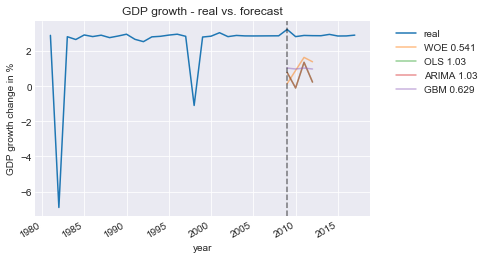

In [124]:
df = database_training[country].append(database_validation[country]).append(database_test[country])

fig, ax = plt.subplots()

ax.plot(df['y'], label='real')

for model in models:
    name = model[0]
    y_forecast = model[1]
    mse = model[2]
    
    label = name + ' ' + str(round(mse,3))
    
    ax.plot(t_forecast_validation,  y_forecast, label=label, alpha=0.5)

ax.axvline(x=start_forecast, ymin=0, ymax=1, color='black',linestyle='--', alpha=0.5)

ax.set_xlabel('year') 
ax.set_ylabel('GDP growth change in %') 
ax.set_title("GDP growth - real vs. forecast")
legend  = ax.legend(bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()
plt.grid()

wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
save_dir = os.path.join(wdir, 'forecast_out_of_time.png')

#plt.savefig(save_dir, dpi = 500, bbox_extra_artists=(legend,), bbox_inches='tight')
#plt.close()

In [83]:
df_validation_sv

,y,PPP,GHG,ExchangeR,"Inflation, average consumer prices",General government net lending/borrowing,Current account balance
2009,0.897871,0.671756,0.661403,0.547551,-2.143655,0.199649,1.210689
2010,0.066762,0.674633,0.692513,0.603493,-0.200409,0.415508,1.167404
2011,1.233105,0.665126,0.651026,0.531534,0.089343,0.193994,1.215372
2012,2.256491,0.687358,0.671881,0.594572,0.830500,0.335610,1.475575
